In [138]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns

load_dotenv()

True

In [139]:
WINDOW_SIZE = 3
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1024'
pdb_code = '6t1z'

In [140]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [160]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
predictions_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
# os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
results_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
# os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id}.txt'

Structure exists: 'pdb/pdb6t1z.ent' 


In [142]:
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


In [5]:
# Get structures
xray = parser.get_structure(pdb_code, xray_fn)

predicted_structures = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predicted_structures.append(parser.get_structure(prediction_pdb.name, prediction_pdb))

0it [00:00, ?it/s]

512it [00:19, 26.37it/s]


In [161]:
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]

# PDBMine

In [51]:
# Get Phi-Psi distribution from PDBMine
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)
code_length = 1
broken_chains = []
# break into sections of length 100
for i in range(0, len(residue_chain), 100-WINDOW_SIZE+1):
    broken_chains.append(residue_chain[i:i+100])

matches = {}
for chain in tqdm(broken_chains):
    if len(chain) < WINDOW_SIZE:
        continue
    response = requests.post(
        PDBMINE_URL + '/v1/api/query',
        json={
            "residueChain": chain,
            "codeLength": code_length,
            "windowSize": WINDOW_SIZE
        }
    )
    assert(response.ok)
    print(response.json())
    query_id = response.json().get('queryID')
    assert(query_id)

    time.sleep(15)
    while(True):
        response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
        if response.ok:
            matchesi = response.json()['frames']
            break
        else:
            print('Waiting')
            time.sleep(15)
    print('Received matches')
    matches.update(matchesi)
json.dump(matches, open('matches.json', 'w'), indent=4)

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


  0%|          | 0/5 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': 'e2d24f29-f817-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 20%|██        | 1/5 [01:42<06:51, 102.82s/it]

Received matches
{'status': 'Running', 'queryID': '201be30f-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 40%|████      | 2/5 [03:17<04:54, 98.26s/it] 

Received matches
{'status': 'Running', 'queryID': '58c5d5d5-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 60%|██████    | 3/5 [04:45<03:07, 93.57s/it]

Received matches
{'status': 'Running', 'queryID': '8d36c06b-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 80%|████████  | 4/5 [06:28<01:37, 97.11s/it]

Received matches
{'status': 'Running', 'queryID': 'ca54789b-f818-11ee-9841-0242ac110002'}


100%|██████████| 5/5 [06:48<00:00, 81.68s/it]

Received matches


In [17]:
matches = json.load(open('matches.json'))

In [7]:
# Get phi-psi by window
phi_psi_mined_by_window_ = []
for seq_win,v in matches.items():
    seq = seq_win#[4:]
    for protein,seq_matches in v.items():
        protein_id, chain = protein.split('_')
        if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
            continue
        for seq_match in seq_matches:
            center_res = seq_match[WINDOW_SIZE//2]
            res, phi, psi = center_res.values()
            phi_psi_mined_by_window_.append([seq, res, phi, psi, chain, protein_id])

phi_psi_mined_by_window = pd.DataFrame(phi_psi_mined_by_window_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
seq_map = {seq.split('_')[1]:seq for seq in phi_psi_mined_by_window['seq'].unique()}
phi_psi_mined_by_window.to_csv('phi_psi_mined_by_window.csv', index=False)

NameError: name 'matches' is not defined

In [8]:
phi_psi_mined_by_window = pd.read_csv('phi_psi_mined_by_window.csv')
seq_map = {seq.split('_')[1]:seq for seq in phi_psi_mined_by_window['seq'].unique()}

# Collect by Window - Xray and predictions

In [17]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]
xray_chain.atom_to_internal_coordinates(verbose=False)
resultDict = structure_rebuild_test(xray_chain)
if not resultDict['pass']:
    raise Exception('Failed to rebuild')
xray_residues = list(xray_chain.get_residues())
xray_phi_psi = []
for i in range(WINDOW_SIZE//2, len(xray_residues) - WINDOW_SIZE // 2):
    # Convert 3 char codes to 1 char codes
    seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in xray_residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
    seq = seq_map.get(seq, f'{i-WINDOW_SIZE//2:03}_{seq}')
    res = seq[-WINDOW_SIZE//2]
    if not xray_residues[i].internal_coord:
        psi,phi = np.nan, np.nan
    else:
        psi = xray_residues[i].internal_coord.get_angle("psi")
        phi = xray_residues[i].internal_coord.get_angle("phi")
        psi = psi if psi else np.nan # if psi is None, set it to np.nan
        phi = phi if phi else np.nan # if phi is None, set it to np.nan
    xray_phi_psi.append([seq, res, phi, psi, xray_chain.id, xray_structure.id])
xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
xray_phi_psi.to_csv('xray_phi_psi.csv', index=False)

In [10]:
# Get phi_psi's of each prediction

def get_phi_psi_by_window(protein_id, protein):
    phi_psi_ = []
    chain = list(prediction[0].get_chains())[0]
    chain.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(chain)
    if not resultDict['pass']:
        raise Exception(f'Failed to rebuild {protein_id} {chain.id}')
    residues = list(chain.get_residues())
    for i in range(WINDOW_SIZE//2, len(residues) - WINDOW_SIZE // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
        seq = seq_map.get(seq, f'{i-WINDOW_SIZE//2:03}_{seq}')
        res = seq[-WINDOW_SIZE//2]
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([seq, res, phi, psi, chain.id, protein.id])
    return phi_psi_
phi_psi_predictions_ = []
for prediction in tqdm(predicted_structures):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            phi_psi_predictions_ += get_phi_psi_by_window(prediction.id, prediction)
        except Exception as e:
            print(e)
phi_psi_predictions_by_window = pd.DataFrame(phi_psi_predictions_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_predictions_by_window.to_csv(f'phi_psi_predictions_by_window.csv', index=False)

  8%|▊         | 18/212 [00:19<03:31,  1.09s/it]

Failed to rebuild T1024TS351_1  


 21%|██        | 44/212 [00:45<03:07,  1.11s/it]

Failed to rebuild T1024TS364_4  


 23%|██▎       | 48/212 [00:48<02:15,  1.21it/s]

Failed to rebuild T1024TS364_1  


 25%|██▍       | 52/212 [00:51<02:03,  1.30it/s]

Failed to rebuild T1024TS364_3  


 32%|███▏      | 68/212 [01:08<02:07,  1.13it/s]

Failed to rebuild T1024TS349_1  


 34%|███▍      | 73/212 [01:12<01:42,  1.35it/s]

Failed to rebuild T1024TS024_5  


 36%|███▋      | 77/212 [01:18<03:51,  1.71s/it]

Failed to rebuild T1024TS349_4  


 41%|████      | 87/212 [01:25<01:39,  1.26it/s]

Failed to rebuild T1024TS107_1  


 46%|████▌     | 97/212 [01:36<01:38,  1.17it/s]

Failed to rebuild T1024TS039_5  


 56%|█████▌    | 118/212 [01:56<01:07,  1.38it/s]

Failed to rebuild T1024TS170_5  


 64%|██████▍   | 136/212 [02:13<00:54,  1.38it/s]

Failed to rebuild T1024TS349_2  


 69%|██████▉   | 146/212 [02:25<01:10,  1.06s/it]

Failed to rebuild T1024TS039_2  


 71%|███████   | 151/212 [02:28<00:47,  1.28it/s]

Failed to rebuild T1024TS458_1  


 72%|███████▏  | 152/212 [02:29<00:43,  1.38it/s]

Failed to rebuild T1024TS349_5  


 75%|███████▌  | 159/212 [02:34<00:41,  1.28it/s]

Failed to rebuild T1024TS364_5  


 77%|███████▋  | 164/212 [02:44<01:28,  1.85s/it]

Failed to rebuild T1024TS024_3  


 78%|███████▊  | 165/212 [02:44<01:09,  1.47s/it]

Failed to rebuild T1024TS458_4  


 88%|████████▊ | 186/212 [03:04<00:59,  2.27s/it]

Failed to rebuild T1024TS061_1  


100%|██████████| 212/212 [03:29<00:00,  1.01it/s]


# Results - By Window

In [1]:
import pandas as pd
phi_psi_mined_by_window = pd.read_csv('phi_psi_mined_by_window.csv')
phi_psi_predictions_by_window = pd.read_csv('phi_psi_predictions_by_window.csv')
xray_phi_psi = pd.read_csv('xray_phi_psi.csv')
phi_psi_mined_by_window['source'] = 'Query (PDBMine)'
phi_psi_predictions_by_window['source'] = 'Prediction'
xray_phi_psi['source'] = 'X-ray'

001_KEF


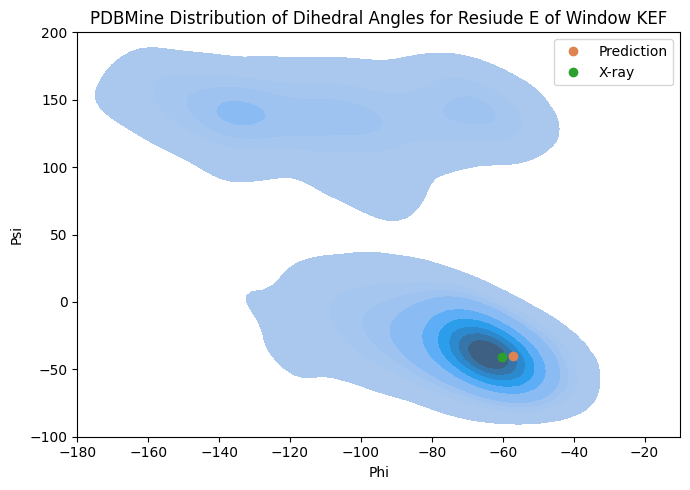

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7,5))

seq = phi_psi_mined_by_window.seq.unique()[1]
print(seq)
phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
phi_psi_alpha = phi_psi_predictions_by_window[(phi_psi_predictions_by_window.protein_id == 'T1024TS427_1') & (phi_psi_predictions_by_window.seq == seq)]
xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq == seq]

sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True)
ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color='#dd8452', label='Prediction')
ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')
ax.legend()
ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude E of Window KEF')
ax.set_xlabel('Phi')
ax.set_ylabel('Psi')
ax.set_xlim(-180, -10)
ax.set_ylim(-100, 200)

plt.tight_layout()

# Mahalanobis

In [4]:
seq = '031_MTI'
from scipy.stats import gaussian_kde
phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
kernel = gaussian_kde(phi_psi_dist[['phi', 'psi']].T)

In [5]:
kernel(0,0)

xray: 0.0030361787056930544
alpha: 0.054811387330703606
preds:                 0
count  503.000000
mean     4.225089
std     29.030947
min      0.002711
25%      0.210616
50%      0.333412
75%      0.534893
max    276.404728


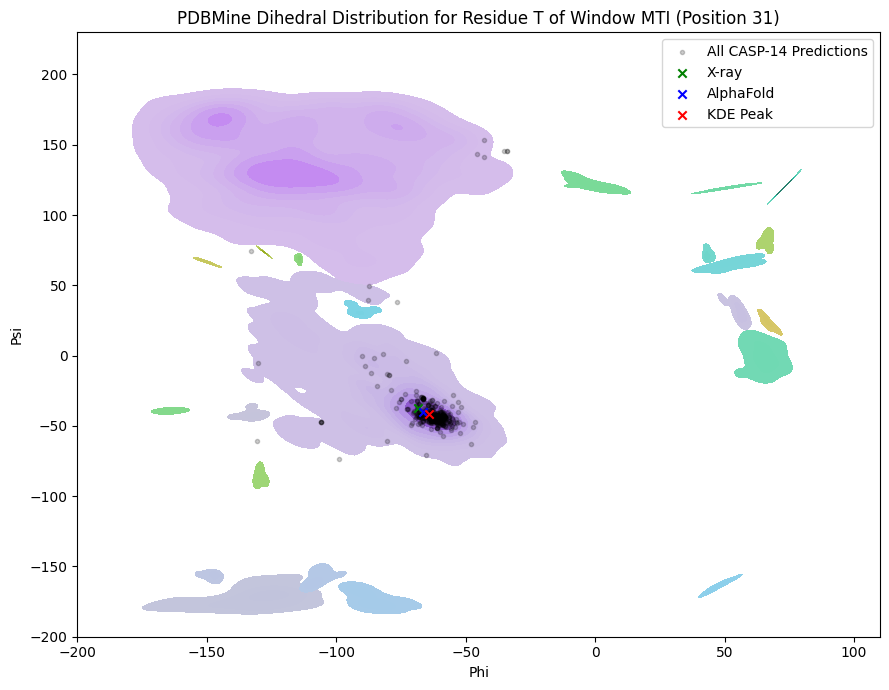

In [155]:
# For one window
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


seq = '031_MTI'
phi_psi_dist = phi_psi_mined_by_window.loc[phi_psi_mined_by_window.seq == seq][['phi','psi']]

# Find clusters
clustering = DBSCAN(eps=7, min_samples=3).fit(phi_psi_dist.values)
phi_psi_dist['cluster'] = clustering.labels_

# Find most probable data point and the cluster it belongs to
kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T)
phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

# Mahalanobis distance to most common cluster
cov = np.cov(phi_psi_c.T)
icov = np.linalg.inv(cov)

# xray
xray = xray_phi_psi[xray_phi_psi.seq == seq][['phi','psi']].values
md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T

# alphafold to most common cluster
alpha = phi_psi_predictions_by_window[(phi_psi_predictions_by_window.protein_id == 'T1024TS427_1') & (phi_psi_predictions_by_window.seq == seq)][['phi','psi']].values
md_alpha = (alpha - phi_psi_c.mean(axis=0)) @ icov @ (alpha - phi_psi_c.mean(axis=0)).T

# Other predictions
preds = phi_psi_predictions_by_window[phi_psi_predictions_by_window.seq == seq][['phi','psi']].values
icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
md_preds = md = (np.expand_dims((preds - phi_psi_c.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi_c.mean(axis=0)), 2)).squeeze()

fig, ax = plt.subplots(figsize=(9,7))
sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', label='X-ray')
ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', label='AlphaFold')
ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', label='KDE Peak')
ax.set_xlim(-200, 110)
ax.set_ylim(-200, 230)
ax.set_xlabel('Phi')
ax.set_ylabel('Psi')
ax.set_title(f'PDBMine Dihedral Distribution for Residue T of Window MTI (Position 31)')
ax.legend()
plt.tight_layout()

# Zoomed in
# fig, ax = plt.subplots(figsize=(7,5))
# sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
# ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
# ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', s=100, label='X-ray')
# ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', s=100, label='AlphaFold')
# ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', s=100, label='KDE Peak')
# ax.set_xlim(-90, -40)
# ax.set_ylim(-80, 0)
# ax.axis('off')
# plt.tight_layout()

print('xray:', md_xray[0,0])
print('alpha:', md_alpha[0,0])
print('preds:', pd.DataFrame(md_preds).describe())

In [15]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

mds = []
phi_psi_predictions_by_window['md'] = np.nan
xray_phi_psi['md'] = np.nan
for i,seq in tqdm(enumerate(phi_psi_mined_by_window.seq.unique())):
    phi_psi_dist = phi_psi_mined_by_window.loc[phi_psi_mined_by_window.seq == seq][['phi','psi']]
    xray = xray_phi_psi[xray_phi_psi.seq == seq][['phi','psi']].values
    preds = phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq][['phi','psi']].values

    if phi_psi_dist.shape[0] < 2 or xray.shape[0] < 1 or preds.shape[0] < 1:
        print(f'Skipping {seq} - not enough data points')
        xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = np.nan
        phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq, 'md'] = np.nan        
        continue
    # Find clusters
    clustering = DBSCAN(eps=10, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable data point and the cluster it belongs to
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T)
    phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
    phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

    # Mahalanobis distance to most common cluster
    cov = np.cov(phi_psi_c.T)
    if np.linalg.det(cov) == 0:
        print(f'Skipping {seq} - singular matrix')
        xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = np.nan
        phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq, 'md'] = np.nan
        continue
    icov = np.linalg.inv(cov)

    # xray
    md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T
    if np.any(md_xray < 0):
        md_xray = np.nan
    else:
        md_xray = np.sqrt(md_xray)[0,0]
    print(md_xray)
    xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = md_xray

    # All predictions
    mean = phi_psi_dist[['phi','psi']].mean(axis=0).values
    md = (np.expand_dims((preds - mean), 1) @ icov @ np.expand_dims((preds - mean), 2)).squeeze()
    if np.any(md < 0):
        md = np.nan
    else:
        md = np.sqrt(md)
    phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq, 'md'] = md

phi_psi_predictions_by_window.to_csv('phi_psi_predictions_by_window_md.csv', index=False)
xray_phi_psi.to_csv('xray_phi_psi_md.csv', index=False)

1it [00:00,  1.76it/s]

Skipping 000_GKE - not enough data points


2it [00:13,  6.65s/it]

0.7267679436163816


In [156]:
phi_psi_predictions_by_window = pd.read_csv('phi_psi_predictions_by_window_md.csv')
xray_phi_psi = pd.read_csv('xray_phi_psi_md.csv')

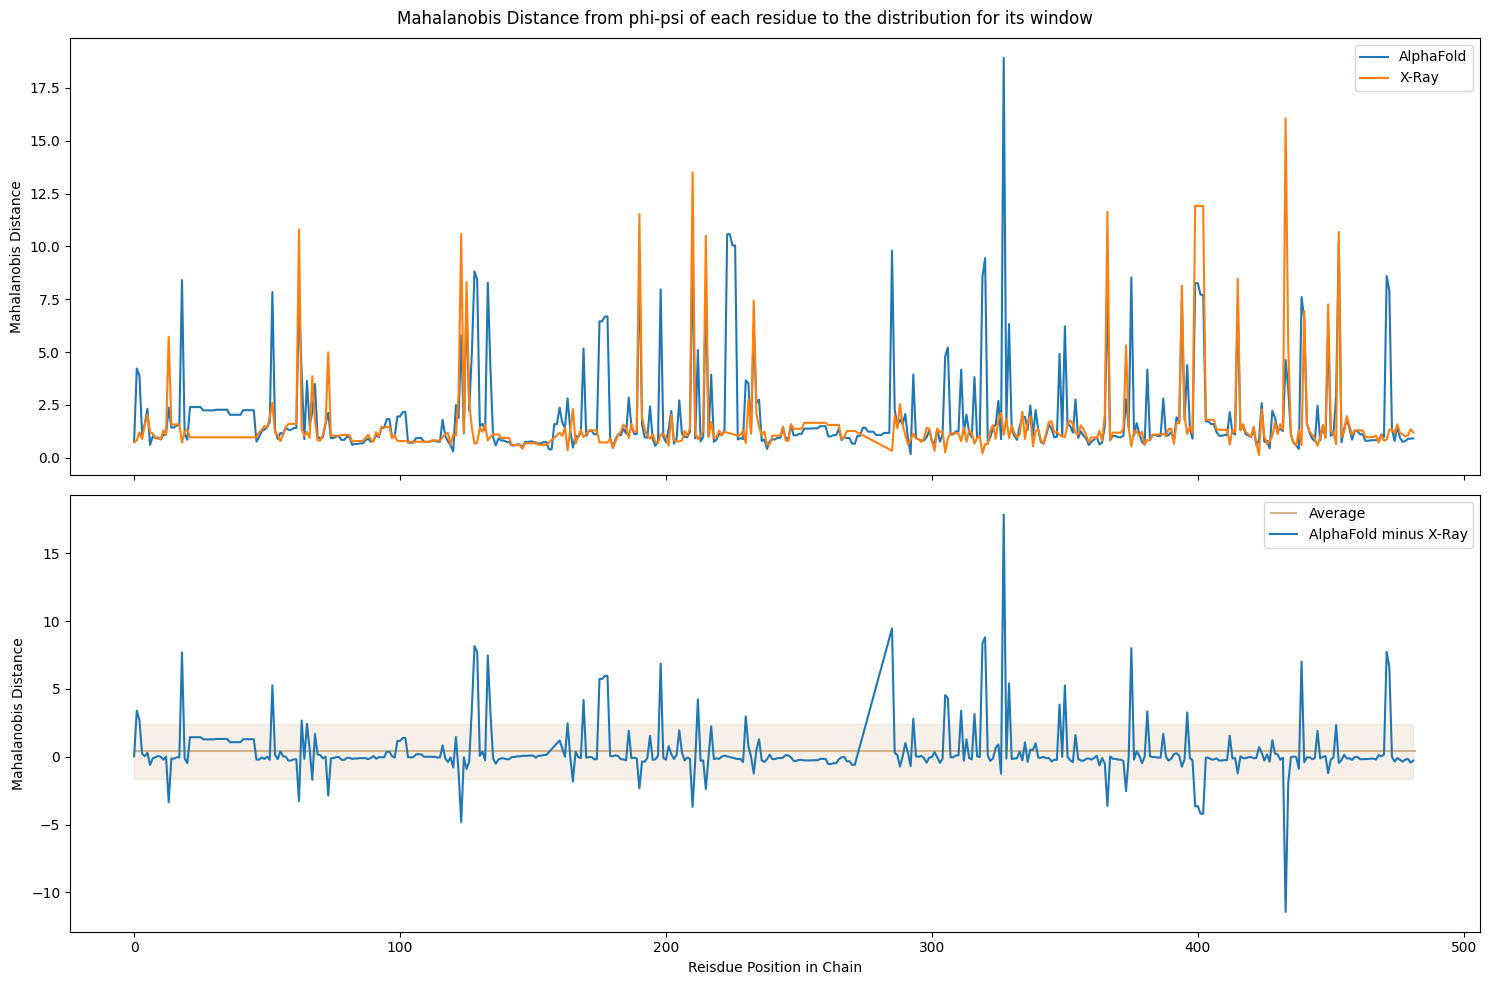

In [107]:
# Plot xray vs prediction md for each residue of one prediction
phi_psi_predictions_by_window['Source'] = 'CASP Prediction'
phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.protein_id == 'T1024TS427_1', 'Source'] = 'AlphaFold'
alpha = phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.protein_id == 'T1024TS427_1']
xray_phi_psi['Source'] = 'X-Ray'
both = pd.merge(alpha, xray_phi_psi, how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
both['md_diff'] = both['md_alpha'] - both['md_xray']
fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
sns.lineplot(data=both.reset_index(), x='index', y='md_alpha', ax=axes[0], label='AlphaFold')
sns.lineplot(data=both.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
axes[0].set_ylabel('Mahalanobis Distance')
axes[1].hlines(both['md_diff'].mean(), xmin=0, xmax=len(both), color='tan', label='Average')
axes[1].fill_between(x=both.index, y1=both['md_diff'].mean() + both['md_diff'].std(), y2=both['md_diff'].mean() - both['md_diff'].std(), color='tan', alpha=0.2)
sns.lineplot(data=both.reset_index(), x='index', y='md_diff', ax=axes[1], label='AlphaFold minus X-Ray')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_xlabel('Reisdue Position in Chain')
fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
plt.tight_layout()

# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

R-squared: 0.306329


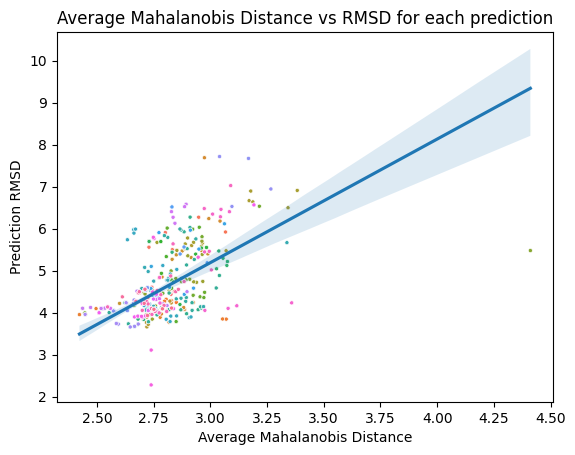

In [170]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress
group_maha = phi_psi_predictions_by_window.groupby(['protein_id'], as_index=False).mean(numeric_only=True)#.sort_values('mahalanobis_dist').set_index('protein_id').dropna()
group_maha = group_maha.merge(results[['Model', 'RMS_ALL']], left_on='protein_id', right_on='Model', how='inner')
group_maha = group_maha[group_maha.RMS_ALL < 8]
fig, ax = plt.subplots()
sns.scatterplot(data=group_maha, x='md', y='RMS_ALL', ax=ax, marker='.', hue='protein_id', legend=False)
sns.regplot(data=group_maha, x='md', y='RMS_ALL', ax=ax, scatter=False, robust=True)
ax.set_xlabel('Average Mahalanobis Distance')
ax.set_ylabel('Prediction RMSD')
ax.set_title('Average Mahalanobis Distance vs RMSD for each prediction')

regr = linregress(group_maha.md, group_maha.RMS_ALL)
print(f"R-squared: {regr.rvalue**2:.6f}")
# # ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

In [44]:
# plot dists with highest mahalanobis distance for alphafold
phi_psi_alpha = phi_psi_predictions_by_window[phi_psi_predictions_by_window.protein_id == 'T1024TS427_1']
seqs_with_highest_maha = phi_psi_alpha.sort_values('md', ascending=False).head(16).seq.values

m = 0
fig, axes = plt.subplots(2,2,figsize=(12,7))
for i,seq in enumerate(seqs_with_highest_maha[m:m+4]):
    phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
    print(phi_psi_dist.shape)
    phi_psi_alpha_seq = phi_psi_alpha[phi_psi_alpha.seq == seq]
    ax = axes.flatten()[i]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')


(32250, 7)
(50025, 7)
